In [1]:
import numpy as np

from emotion_trainer import ImprovedDeepEmbeddedClustering
from modules import Emotion_DataModule_Unsupervised
from utils import *


seed = 2222
ManualSeed(seed)

learning_rate = 1e-4
num_batch = 64
num_epochs = 500
num_subj = 32

tr_loss = []
vl_loss = []
ts_acc = []
preds = np.zeros((num_subj,60)) # model predictions
targets = np.zeros((num_subj,60)) # labels

subj = 0
emotion_dataset = Emotion_DataModule_Unsupervised('D:\One_한양대학교\private object minsu\coding\data\samsung_2024\emotion',
                                        test_subj=subj, 
                                        sample_half=True,
                                        channel_mode=3,
                                        window_len=12,
                                        overlap_len=6,
                                        num_train=30,
                                        batch_size=num_batch,
                                        transform=None)
test_loader = emotion_dataset.test_loader
val_loader = emotion_dataset.val_loader
train_loader = emotion_dataset.train_loader

clustering = ImprovedDeepEmbeddedClustering(embed_dim=1,
                                            in_chan=2,
                                            hid_chan=32,
                                            z_chan=4,
                                            n_clusters=4,
                                            optimizer_name='Adam',
                                            learning_rate=str(learning_rate),
                                            criterion_mode=0)

In [2]:
clustering.pretrain(train_loader, epochs=num_epochs)

Pretraining...
Epoch 1/500, Loss: 569.4433
Epoch 2/500, Loss: 495.5742
Epoch 3/500, Loss: 455.9292
Epoch 4/500, Loss: 424.2990
Epoch 5/500, Loss: 397.2282
Epoch 6/500, Loss: 372.8504
Epoch 7/500, Loss: 351.0265
Epoch 8/500, Loss: 330.8979
Epoch 9/500, Loss: 313.1929
Epoch 10/500, Loss: 296.9807
Epoch 11/500, Loss: 282.0325
Epoch 12/500, Loss: 268.9299
Epoch 13/500, Loss: 257.4913
Epoch 14/500, Loss: 246.1032
Epoch 15/500, Loss: 236.1325
Epoch 16/500, Loss: 225.3137
Epoch 17/500, Loss: 215.2279
Epoch 18/500, Loss: 209.8144
Epoch 19/500, Loss: 201.3666
Epoch 20/500, Loss: 190.6609
Epoch 21/500, Loss: 185.7117
Epoch 22/500, Loss: 179.1845
Epoch 23/500, Loss: 172.8024
Epoch 24/500, Loss: 164.8277
Epoch 25/500, Loss: 162.3684
Epoch 26/500, Loss: 155.1872
Epoch 27/500, Loss: 150.7764
Epoch 28/500, Loss: 146.9809
Epoch 29/500, Loss: 147.2034
Epoch 30/500, Loss: 145.3739
Epoch 31/500, Loss: 142.7798
Epoch 32/500, Loss: 137.2043
Epoch 33/500, Loss: 135.2441
Epoch 34/500, Loss: 130.2807
Epoch 35

In [3]:
clustering.fit(train_loader, epochs=num_epochs)

Training...


c:\Users\user\anaconda3\envs\t2\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Epoch 1/500, Loss: 1.6319
Epoch 2/500, Loss: 1.4849
Epoch 3/500, Loss: 1.4140
Epoch 4/500, Loss: 1.3825
Epoch 5/500, Loss: 1.3730
Epoch 6/500, Loss: 1.3789
Epoch 7/500, Loss: 1.4025
Epoch 8/500, Loss: 1.4536
Epoch 9/500, Loss: 1.5333
Epoch 10/500, Loss: 1.6500
Epoch 11/500, Loss: 1.8268
Epoch 12/500, Loss: 2.1032
Epoch 13/500, Loss: 2.5392
Epoch 14/500, Loss: 3.2086
Epoch 15/500, Loss: 4.2524
Epoch 16/500, Loss: 5.7171
Epoch 17/500, Loss: 7.8604
Epoch 18/500, Loss: 9.0026
Epoch 19/500, Loss: 10.5218
Epoch 20/500, Loss: 10.2791
Epoch 21/500, Loss: 10.3509
Epoch 22/500, Loss: 7.2901
Epoch 23/500, Loss: 9.8877
Epoch 24/500, Loss: 9.1594
Epoch 25/500, Loss: 9.1689
Epoch 26/500, Loss: 7.7574
Epoch 27/500, Loss: 7.8868
Epoch 28/500, Loss: 8.1061
Epoch 29/500, Loss: 8.9005
Epoch 30/500, Loss: 8.5695
Epoch 31/500, Loss: 9.1646
Epoch 32/500, Loss: 7.7127
Epoch 33/500, Loss: 7.9443
Epoch 34/500, Loss: 7.8124
Epoch 35/500, Loss: 8.6222
Epoch 36/500, Loss: 7.2166
Epoch 37/500, Loss: 8.5530
Epoch 3

In [4]:
from sklearn.metrics import normalized_mutual_info_score
# 클러스터링 평가
encoded_data = []
labels1 = []
labels2 = []
with torch.no_grad():
    for batch in train_loader:
        x,y1,y2 = batch
        x = x.to(DEVICE)
        mu, sigma = clustering.ae.encode(x)
        z = clustering.ae.sampling(mu, sigma)
        encoded_data.append(z)
        labels1.append(y1.numpy())
        labels2.append(y2.numpy())
encoded_data = torch.cat(encoded_data).cpu().numpy()
y_pred_final = clustering.kmeans.predict(np.squeeze(encoded_data))
labels1, labels2 = np.concatenate(labels1), np.concatenate(labels2)
nmi1 = normalized_mutual_info_score(labels1, y_pred_final)
nmi2 = normalized_mutual_info_score(labels2, y_pred_final)
print(f"NMI1: {nmi1:.4f}, NMI2: {nmi2:.4f}")

NMI1: 0.0019, NMI2: 0.0037


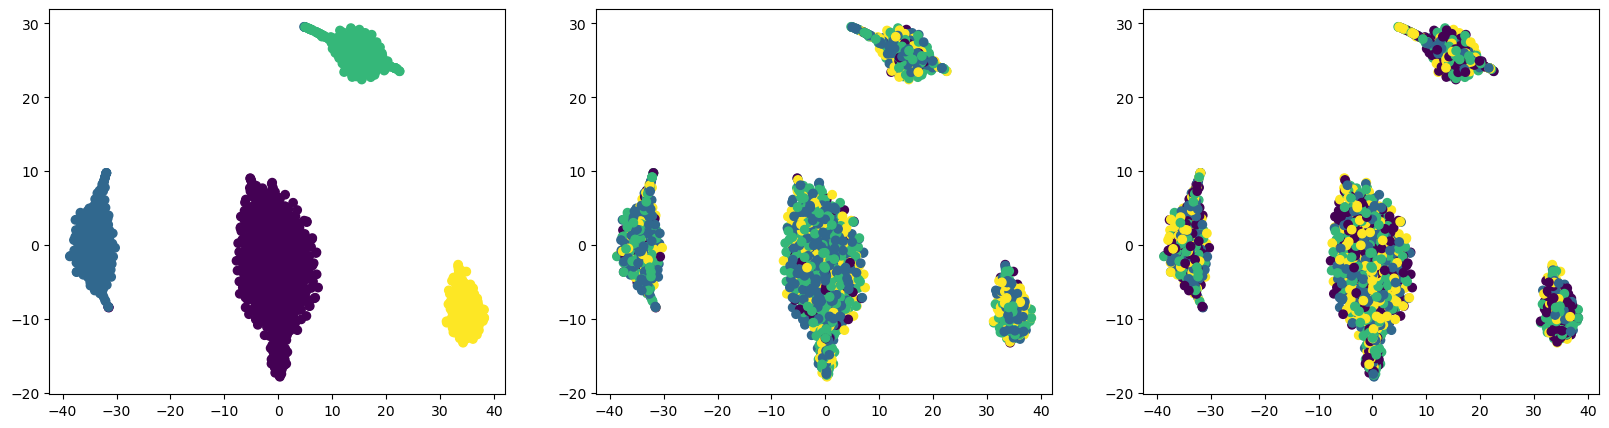

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(np.squeeze(encoded_data))
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_pred_final)
plt.subplot(132)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels1)
plt.subplot(133)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels2)